<a href="https://colab.research.google.com/github/ArmandOvanessians/Disorder/blob/main/Prot_Lang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install hp5

ERROR: Could not find a version that satisfies the requirement hp5 (from versions: none)
ERROR: No matching distribution found for hp5


In [2]:
# Google Colab Specific Imports
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = '/content/drive/My Drive/Disorder/Embeddings/per_protein_embeddings.h5'

In [6]:
import h5py
import torch

# Load the HDF5 file
with h5py.File(data, "r") as h5_file:
    # Suppose each protein sequence has its embedding stored as a dataset
    # Check the dataset names or structure if unsure
    embeddings_list = []
    for protein_id in h5_file.keys():
        embeddings = h5_file[protein_id][()]  # Load the numpy array for each protein
        embeddings_list.append(embeddings)

    # Stack all embeddings into a single numpy array or PyTorch tensor
    embeddings_array = torch.tensor(embeddings_list)

<ipython-input-6-dc6e679ab3fb>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  embeddings_array = torch.tensor(embeddings_list)


In [7]:
print(embeddings_array.shape)
# Expected output shape might be (num_proteins, embedding_dimension)


torch.Size([693, 1024])


In [8]:
import h5py
import torch

# Load the HDF5 file
with h5py.File(data, "r") as h5_file:
    # Get the list of protein IDs (keys)
    protein_ids = list(h5_file.keys())

    # Loop through the first 5 proteins and print their embeddings
    for i, protein_id in enumerate(protein_ids[:5]):
        embedding = h5_file[protein_id][()]  # Load the numpy array for each protein
        embedding_tensor = torch.tensor(embedding)  # Convert to a PyTorch tensor
        print(f"Protein ID: {protein_id}")
        print("Embedding:", embedding_tensor.shape)
        print()  # Print a new line for readability


Protein ID: AEBP2-2
Embedding: torch.Size([1024])

Protein ID: AEBP2-3
Embedding: torch.Size([1024])

Protein ID: ARNT2-1
Embedding: torch.Size([1024])

Protein ID: ARNT2-2
Embedding: torch.Size([1024])

Protein ID: ARNT2-3
Embedding: torch.Size([1024])



In [9]:
import pandas as pd
data_iso = '/content/drive/My Drive/Disorder/Input_data/ISO_FULL.CSV'
df_iso = pd.read_csv(data_iso)

In [10]:
df_iso.head()

,ID,REP_Q2,REP_N2,REP_S2,REP_G2,REP_E2,REP_D2,REP_K2,REP_R2,REP_P2,...,net_charge,WF_complexity,KL_hydropathy,isoelectric_point,FCR,ED_ratio,RK_ratio,SCD,omega*,Class
0,ARNT2-1,1.309662,-0.618361,2.397098,-0.383163,-0.660254,0.761530,0.217436,1.618940,0.285942,...,-0.381542,0.947422,0.086818,-0.520538,-0.570053,-0.362143,0.635850,-0.098020,0.075008,1
1,ARNT2-2,1.309662,-0.618361,2.397098,-0.383163,-0.660254,0.761530,0.217436,1.618940,-0.248339,...,0.205181,0.887692,0.080876,0.343694,-0.548616,-0.255840,0.686459,-0.088509,-0.492538,1
2,ATF2-2,0.200936,-0.618361,1.682995,-0.916464,0.293757,1.575578,1.366979,0.897295,-0.515480,...,-0.014840,-0.239688,0.131963,-0.204469,-0.472345,-0.156335,-0.351880,-0.219513,-1.391212,1
3,ATF2-5,-0.242554,-0.618361,-0.221281,-0.916464,-0.183249,0.761530,0.217436,-1.267640,-0.782620,...,-0.234861,-0.461494,0.377617,-0.791120,0.032233,-0.504160,-1.311613,-0.034336,-1.361816,1
4,CREB1-1,0.200936,0.371597,0.016753,-0.383163,0.770763,-0.866568,-0.357336,0.897295,-0.782620,...,-0.234861,-0.562249,0.441422,-1.004554,-0.573718,0.559435,0.101002,-0.179989,0.781130,1


In [11]:
import h5py
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, h5_file_path, df, class_col='Class'):
        """
        Initializes the dataset by creating a list of embeddings and class labels from the HDF5 file and DataFrame.

        Parameters:
        - h5_file_path: Path to the HDF5 file containing protein embeddings.
        - df: DataFrame containing protein IDs and class labels.
        - class_col: Column name for the label. Defaults to 'Class'.
        """
        self.data = []

        # Load the HDF5 file
        with h5py.File(h5_file_path, "r") as h5_file:
            # Filter protein IDs to include only those present in the DataFrame's "ID" column
            valid_protein_ids = set(df['ID']).intersection(h5_file.keys())

            # Loop through the valid protein IDs
            for protein_id in valid_protein_ids:
                embedding = h5_file[protein_id][()]  # Load the numpy array for each protein
                embedding_tensor = torch.tensor(embedding, dtype=torch.float)  # Convert to a PyTorch tensor

                # Get the class label from the DataFrame
                label = torch.tensor(df.loc[df['ID'] == protein_id, class_col].values[0], dtype=torch.float)

                # Append the embedding, label, and protein ID as a dictionary
                self.data.append({'embedding': embedding_tensor, 'label': label, 'ID': protein_id})

    def __len__(self):
        # Return the number of embeddings
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single embedding and its label
        data = self.data[idx]
        return data['embedding'], data['label'], data['ID']

# Instantiate the dataset
#data_path = "path_to_your_h5_file.h5"  # Replace with your actual HDF5 file path
dataset = SequenceDataset(h5_file_path=data, df=df_iso)

# Print out the dimensions and class labels for each entry
for embedding, label, protein_id in dataset:
    print(f"Protein ID: {protein_id}")
    print(f"Embedding Dimension: {embedding.size()}")
    print(f"Class Label: {label}")
    print()  # Print a new line for readability


Protein ID: ZNF143-2
Embedding Dimension: torch.Size([1024])
Class Label: 1.0

Protein ID: NKX2-5-1
Embedding Dimension: torch.Size([1024])
Class Label: 1.0

Protein ID: NR4A1-3
Embedding Dimension: torch.Size([1024])
Class Label: 1.0

Protein ID: ZNF473-2
Embedding Dimension: torch.Size([1024])
Class Label: 1.0

Protein ID: DLX5-1
Embedding Dimension: torch.Size([1024])
Class Label: 1.0

Protein ID: FOXP2-2
Embedding Dimension: torch.Size([1024])
Class Label: 1.0

Protein ID: NFATC1-1
Embedding Dimension: torch.Size([1024])
Class Label: 1.0

Protein ID: SPDEF-3
Embedding Dimension: torch.Size([1024])
Class Label: 1.0

Protein ID: FOXP2-1
Embedding Dimension: torch.Size([1024])
Class Label: 1.0

Protein ID: RARB-1
Embedding Dimension: torch.Size([1024])
Class Label: 1.0

Protein ID: ZNF415-2
Embedding Dimension: torch.Size([1024])
Class Label: 0.0

Protein ID: ZNF613-1
Embedding Dimension: torch.Size([1024])
Class Label: 0.0

Protein ID: ZNF691-1
Embedding Dimension: torch.Size([1024])

In [12]:
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
# from torch.utils.data import DataLoader, Subset, ConcatDataset
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import KFold
# class MLPBinaryClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.1):
#         super(MLPBinaryClassifier, self).__init__()
#         layers = []
#         prev_dim = input_dim
#         for dim in hidden_dims:
#             layers.append(nn.Linear(prev_dim, dim))
#             layers.append(nn.LayerNorm(dim))
#             layers.append(nn.ReLU())
#             layers.append(nn.Dropout(dropout))
#             prev_dim = dim
#         layers.append(nn.Linear(prev_dim, 1))
#         layers.append(nn.Sigmoid())
#         self.network = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.network(x)
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 128, 128], dropout=0.3):
        super(MLPBinaryClassifier, self).__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.LayerNorm(dim))  # Use LayerNorm for stability
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [13]:
class ResidualMLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_blocks=4, dropout=0.3):
        super(ResidualMLPBinaryClassifier, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Residual blocks with consistent dimensions
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for _ in range(num_blocks)
        ])

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.residual_blocks:
            x = block(x) + x  # Residual connection within each block
        return self.output_layer(x)


In [14]:
# class EnhancedCNNMLPBinaryClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dims=[128, 64], conv_out_channels=64, kernel_size=3, dropout=0.1):
#         super(EnhancedCNNMLPBinaryClassifier, self).__init__()
#         self.conv1d = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size),
#             nn.ReLU(),
#             nn.MaxPool1d(2),  # Pooling layer to reduce dimensionality
#             nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=kernel_size),
#             nn.ReLU(),
#             nn.MaxPool1d(2)  # Additional pooling
#         )

#         self.flattened_dim = conv_out_channels * 2 * ((input_dim - 2 * (kernel_size - 1)) // 4)  # Adjust based on pooling
#         self.mlp_layers = nn.Sequential(
#             nn.Linear(self.flattened_dim, hidden_dims[0]),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dims[0], hidden_dims[1]),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dims[1], 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension for Conv1D
#         x = self.conv1d(x)
#         x = x.view(x.size(0), -1)  # Flatten for MLP
#         return self.mlp_layers(x)
# class EnhancedCNNMLPBinaryClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dims=[128, 64], conv_out_channels=64, kernel_size=3, dropout=0.1):
#         super(EnhancedCNNMLPBinaryClassifier, self).__init__()

#         # Define the Conv1D layers
#         self.conv1d = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size),
#             nn.ReLU(),
#             nn.MaxPool1d(2),  # Halves the dimension
#             nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=kernel_size),
#             nn.ReLU(),
#             nn.MaxPool1d(2)  # Halves the dimension again
#         )

#         # Calculate the output dimension after Conv1D and pooling
#         conv1_output_dim = input_dim - (kernel_size - 1)  # After first Conv1D layer
#         pooled1_output_dim = conv1_output_dim // 2       # After first pooling
#         conv2_output_dim = pooled1_output_dim - (kernel_size - 1)  # After second Conv1D layer
#         pooled2_output_dim = conv2_output_dim // 2        # After second pooling

#         # Compute flattened dimension
#         self.flattened_dim = pooled2_output_dim * conv_out_channels * 2  # *2 for the output channels of the last conv layer

#         # Define the MLP layers
#         self.mlp_layers = nn.Sequential(
#             nn.Linear(self.flattened_dim, hidden_dims[0]),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dims[0], hidden_dims[1]),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dims[1], 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension for Conv1D
#         x = self.conv1d(x)
#         x = x.view(x.size(0), -1)  # Flatten for MLP
#         return self.mlp_layers(x)
# import torch
# import torch.nn as nn

# class EnhancedCNNMLPBinaryClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dims=[64, 32], conv_out_channels=32, kernel_size=3, dropout=0.5):
#         super(EnhancedCNNMLPBinaryClassifier, self).__init__()

#         # Define the Conv1D layers with Batch Normalization and Dropout
#         self.conv1d = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size),
#             nn.BatchNorm1d(conv_out_channels),
#             nn.ReLU(),
#             nn.MaxPool1d(2),  # Halves the dimension
#             nn.Dropout(dropout),  # Apply dropout after pooling
#             nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=kernel_size),
#             nn.BatchNorm1d(conv_out_channels * 2),
#             nn.ReLU(),
#             nn.MaxPool1d(2),  # Halves the dimension again
#             nn.Dropout(dropout)  # Apply dropout after pooling
#         )

#         # Calculate the output dimension after Conv1D and pooling
#         conv1_output_dim = input_dim - (kernel_size - 1)
#         pooled1_output_dim = conv1_output_dim // 2
#         conv2_output_dim = pooled1_output_dim - (kernel_size - 1)
#         pooled2_output_dim = conv2_output_dim // 2

#         # Compute flattened dimension
#         self.flattened_dim = pooled2_output_dim * conv_out_channels * 2  # *2 for the output channels of the last conv layer

#         # Define the MLP layers with Batch Normalization and Dropout
#         self.mlp_layers = nn.Sequential(
#             nn.Linear(self.flattened_dim, hidden_dims[0]),
#             nn.BatchNorm1d(hidden_dims[0]),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dims[0], hidden_dims[1]),
#             nn.BatchNorm1d(hidden_dims[1]),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dims[1], 1)
#         )

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension for Conv1D
#         x = self.conv1d(x)
#         x = x.view(x.size(0), -1)  # Flatten for MLP
#         x = self.mlp_layers(x)
#         return x  # Output logits for use with BCEWithLogitsLoss


# import torch
# import torch.nn as nn

# class EnhancedCNNMLPBinaryClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dims=[128, 64], conv_out_channels=32, kernel_size=3, dropout=0.5):
#         super(EnhancedCNNMLPBinaryClassifier, self).__init__()

#         # Define Conv1D layers with Batch Normalization and Dropout
#         self.conv1d = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size),
#             nn.BatchNorm1d(conv_out_channels),
#             nn.ReLU(),
#             nn.MaxPool1d(2),
#             nn.Dropout(dropout),
#             nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=kernel_size),
#             nn.BatchNorm1d(conv_out_channels * 2),
#             nn.ReLU(),
#             nn.MaxPool1d(2),
#             nn.Dropout(dropout)
#         )

#         # Calculate the flattened dimension after Conv1D and pooling
#         conv1_output_dim = input_dim - (kernel_size - 1)
#         pooled1_output_dim = conv1_output_dim // 2
#         conv2_output_dim = pooled1_output_dim - (kernel_size - 1)
#         pooled2_output_dim = conv2_output_dim // 2
#         self.flattened_dim = pooled2_output_dim * conv_out_channels * 2

#         # Define MLP layers with Batch Normalization and Dropout
#         self.mlp_layers = nn.Sequential(
#             nn.Linear(self.flattened_dim, hidden_dims[0]),
#             nn.BatchNorm1d(hidden_dims[0]),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dims[0], hidden_dims[1]),
#             nn.BatchNorm1d(hidden_dims[1]),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dims[1], 1)  # Output raw logits
#         )

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension for Conv1D
#         x = self.conv1d(x)
#         x = x.view(x.size(0), -1)  # Flatten for MLP
#         x = self.mlp_layers(x)
#         return x  # Return raw logits for BCEWithLogitsLoss

import torch
import torch.nn as nn

class EnhancedCNNMLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], conv_out_channels=32, kernel_size=3, dropout=0.5):
        super(EnhancedCNNMLPBinaryClassifier, self).__init__()

        # Define Conv1D layers with Batch Normalization and Dropout
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(conv_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=kernel_size),
            nn.BatchNorm1d(conv_out_channels * 2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout)
        )

        # Calculate the flattened dimension after Conv1D and pooling
        conv1_output_dim = input_dim - (kernel_size - 1)
        pooled1_output_dim = conv1_output_dim // 2
        conv2_output_dim = pooled1_output_dim - (kernel_size - 1)
        pooled2_output_dim = conv2_output_dim // 2
        self.flattened_dim = pooled2_output_dim * conv_out_channels * 2

        # Define MLP layers with Batch Normalization and Dropout
        self.mlp_layers = nn.Sequential(
            nn.Linear(self.flattened_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], 1)  # Output raw score
        )

        # Sigmoid layer to constrain output between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1D
        x = self.conv1d(x)
        x = x.view(x.size(0), -1)  # Flatten for MLP
        x = self.mlp_layers(x)
        return self.sigmoid(x)  # Apply Sigmoid to output for BCELoss


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedCNNBinaryClassifier(nn.Module):
    def __init__(self, input_dim, conv_out_channels=64, hidden_dims=[128, 64], dropout=0.3):
        super(AdvancedCNNBinaryClassifier, self).__init__()

        # Initial Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(conv_out_channels)

        # Second Convolutional Block with residual connection
        self.conv3 = nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=conv_out_channels * 2, out_channels=conv_out_channels * 2, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm1d(conv_out_channels * 2)

        # 1x1 Convolution to match dimensions for residual connection
        self.residual_connection = nn.Conv1d(conv_out_channels, conv_out_channels * 2, kernel_size=1)

        # Global Average Pooling layer to reduce dimensions
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        flattened_dim = conv_out_channels * 2
        self.fc1 = nn.Linear(flattened_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.output = nn.Linear(hidden_dims[1], 1)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Initial Conv Block
        residual = x.unsqueeze(1)  # (batch_size, 1, input_dim)
        x = F.relu(self.conv1(residual))
        x = self.conv2(x)
        x = self.batch_norm1(x)
        x = F.relu(x + residual)  # Residual connection

        # Second Conv Block
        residual = self.residual_connection(x)  # Adjust residual to match output channels
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.batch_norm2(x)
        x = F.relu(x + residual)  # Residual connection

        # Global Average Pooling
        x = self.global_pool(x).squeeze(-1)  # (batch_size, conv_out_channels * 2)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Output Layer
        return torch.sigmoid(self.output(x))


In [16]:
import torch
from torch import nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, nhead=8, num_layers=4, dropout=0.2):
        super(TransformerBinaryClassifier, self).__init__()

        # Initial convolutional embedding
        self.embedding_conv = nn.Conv1d(1, hidden_dim, kernel_size=3, padding=1)

        # Transformer layers
        encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected output layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1D
        x = self.embedding_conv(x).permute(2, 0, 1)  # Convert to (seq_len, batch_size, hidden_dim)

        # Dynamically create positional encoding based on x's shape
        seq_len, batch_size, hidden_dim = x.size()
        position = torch.arange(seq_len, device=x.device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, hidden_dim, 2, device=x.device).float() * (-torch.log(torch.tensor(10000.0)) / hidden_dim))

        positional_encoding = torch.zeros((seq_len, batch_size, hidden_dim), device=x.device)
        positional_encoding[:, :, 0::2] = torch.sin(position * div_term).unsqueeze(1)
        positional_encoding[:, :, 1::2] = torch.cos(position * div_term).unsqueeze(1)

        # Add positional encoding to x
        x = x + positional_encoding

        # Apply transformer encoder and aggregate over the sequence dimension
        x = self.transformer_encoder(x).mean(dim=0)

        # Pass through the output layer
        return self.fc(x)


In [38]:
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn as nn

def save_fold_data(fold, train_indices, train_ids, val_indices, val_ids):
    """Save training and validation data (both indices and IDs) for each fold."""
    fold_data = {
        'train_indices': train_indices,
        'train_ids': train_ids,
        'val_indices': val_indices,
        'val_ids': val_ids
    }
    with open(f"fold_{fold + 1}_data.pkl", "wb") as file:
        pickle.dump(fold_data, file)
    print(f"Training and validation data (indices and IDs) for Fold {fold + 1} saved.")

def train_and_evaluate_model_non_overlap(dataset, df, device, model_class, num_epochs=10, batch_size=32,
                                         learning_rate=1e-4, hidden_dim=64, pos_weight=1.0, neg_weight=1.0,
                                         k_folds=5, augment_minority_class=False, weight_decay=0.0,
                                         patience=10):

    first_sequence, _, _ = dataset[0]
    input_dim = first_sequence.shape[-1]

    gene_to_indices = {}
    for idx, (_, _, gene_id) in enumerate(dataset):
        gene_name = gene_id.split("-")[0]
        if gene_name not in gene_to_indices:
            gene_to_indices[gene_name] = []
        gene_to_indices[gene_name].append(idx)

    gene_classes = []
    for gene_name, indices in gene_to_indices.items():
        gene_ids = [dataset[i][2] for i in indices]
        class_labels = df[df['ID'].isin(gene_ids)]['Class']
        majority_class = class_labels.mode()[0]
        gene_classes.append((gene_name, majority_class))

    gene_names, gene_labels = zip(*gene_classes)

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = []
    best_val_accuracy = 0.0
    best_model_state = None

    for fold, (train_gene_idxs, val_gene_idxs) in enumerate(skf.split(gene_names, gene_labels)):
        print(f"FOLD {fold + 1}/{k_folds}")

        train_genes = [gene_names[i] for i in train_gene_idxs]
        val_genes = [gene_names[i] for i in val_gene_idxs]

        train_indices = [idx for gene in train_genes for idx in gene_to_indices[gene]]
        val_indices = [idx for gene in val_genes for idx in gene_to_indices[gene]]

        train_ids = [dataset[idx][2] for idx in train_indices]
        val_ids = [dataset[idx][2] for idx in val_indices]

        save_fold_data(fold, train_indices, train_ids, val_indices, val_ids)

        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        model = model_class(input_dim=input_dim, hidden_dims=[128, 64, 32] if model_class != "TransformerBinaryClassifier" else hidden_dim, dropout=0.1).to(device)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        criterion = nn.BCELoss(reduction='none')
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        best_val_loss = float('inf')
        epochs_without_improvement = 0

        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

        for epoch in range(num_epochs):
            model.train()
            train_loss, correct_train, total_train = 0, 0, 0

            for batch in train_loader:
                sequences, labels, _ = batch
                sequences, labels = sequences.to(device), labels.to(device)

                weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                logits = model(sequences).squeeze(dim=1)
                loss_per_sample = criterion(logits, labels.float())
                loss = (loss_per_sample * weight).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * sequences.size(0)
                preds = (logits > 0.5).float()
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            train_losses.append(train_loss / total_train)
            train_accuracies.append(correct_train / total_train)

            model.eval()
            val_loss, correct_val, total_val = 0, 0, 0
            val_labels, val_preds = [], []
            val_logits = []

            with torch.no_grad():
                for batch in val_loader:
                    sequences, labels, _ = batch
                    sequences, labels = sequences.to(device), labels.to(device)

                    logits = model(sequences).squeeze()
                    loss_per_sample = criterion(logits.view(-1), labels.float().view(-1))
                    weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                    val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                    predictions = (logits > 0.5).float()
                    correct_val += (predictions == labels).sum().item()
                    total_val += labels.size(0)
                    val_labels.extend(labels.cpu().numpy())
                    val_preds.extend(predictions.cpu().numpy())
                    val_logits.extend(logits.cpu().numpy())

            val_losses.append(val_loss / total_val)
            val_accuracies.append(correct_val / total_val)

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

        precision = precision_score(val_labels, val_preds, zero_division=0)
        recall = recall_score(val_labels, val_preds)
        f1 = f1_score(val_labels, val_preds)
        auc_roc = roc_auc_score(val_labels, val_logits)

        print(f"Fold {fold + 1} Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

        cm = confusion_matrix(val_labels, val_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
        disp.plot(cmap="Blues")
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.show()

        results.append({
            'Fold': fold + 1,
            'Validation Accuracy': val_accuracies[-1],
            'Validation Loss': val_losses[-1],
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC-ROC': auc_roc
        })

    avg_accuracy = sum(result['Validation Accuracy'] for result in results) / k_folds
    avg_precision = sum(result['Precision'] for result in results) / k_folds
    avg_recall = sum(result['Recall'] for result in results) / k_folds
    avg_f1 = sum(result['F1 Score'] for result in results) / k_folds
    avg_auc_roc = sum(result['AUC-ROC'] for result in results) / k_folds

    print(f"\nAverage Validation Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print(f"Average AUC-ROC: {avg_auc_roc:.4f}")

    return best_model_state, train_losses, val_losses, train_accuracies, val_accuracies, avg_accuracy


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_state, train_losses, val_losses, train_accuracies, val_accuracies, avg_accuracy = train_and_evaluate_model_non_overlap(
    df = df_iso,
    dataset=dataset,
    device=device,
    model_class=EnhancedCNNMLPBinaryClassifier,
    num_epochs=100,
    batch_size=16,
    learning_rate=0.0001,
    pos_weight=1,
    neg_weight=10,
    k_folds=2,
    hidden_dim=32,
    augment_minority_class=True,
    weight_decay=.1,
    patience=15
)

FOLD 1/2
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 1.4784, Val Loss: 1.5774, Train Acc: 0.3540, Val Acc: 0.1444
Epoch [2/100], Train Loss: 1.4694, Val Loss: 1.5711, Train Acc: 0.1863, Val Acc: 0.1444
Epoch [3/100], Train Loss: 1.4572, Val Loss: 1.5571, Train Acc: 0.1491, Val Acc: 0.1444
Epoch [4/100], Train Loss: 1.4558, Val Loss: 1.5292, Train Acc: 0.1242, Val Acc: 0.1444
Epoch [5/100], Train Loss: 1.4540, Val Loss: 1.5374, Train Acc: 0.1242, Val Acc: 0.1444
Epoch [6/100], Train Loss: 1.4521, Val Loss: 1.5454, Train Acc: 0.1242, Val Acc: 0.1444
Epoch [7/100], Train Loss: 1.4379, Val Loss: 1.5409, Train Acc: 0.1242, Val Acc: 0.1444
Epoch [8/100], Train Loss: 1.4512, Val Loss: 1.5406, Train Acc: 0.1242, Val Acc: 0.1444
Epoch [9/100], Train Loss: 1.4428, Val Loss: 1.5253, Train Acc: 0.1242, Val Acc: 0.1444
Epoch [10/100], Train Loss: 1.4441, Val Loss: 1.5476, Train Acc: 0.1242, Val Acc: 0.1444
Epoch [11/100], Train Loss: 1.4571, Val Loss:

KeyboardInterrupt: 

BenchMark different models

In [66]:
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn as nn

def save_fold_data(fold, train_indices, train_ids, val_indices, val_ids):
    """Save training and validation data (both indices and IDs) for each fold."""
    fold_data = {
        'train_indices': train_indices,
        'train_ids': train_ids,
        'val_indices': val_indices,
        'val_ids': val_ids
    }
    with open(f"fold_{fold + 1}_data.pkl", "wb") as file:
        pickle.dump(fold_data, file)
    print(f"Training and validation data (indices and IDs) for Fold {fold + 1} saved.")

def benchmark_models(dataset, df, device, model_classes, num_epochs=10, batch_size=32,
                     learning_rate=1e-4, hidden_dim=64, pos_weight=1.0, neg_weight=1.0,
                     k_folds=5, augment_minority_class=False, weight_decay=0.0,
                     patience=10):

    first_sequence, _, _ = dataset[0]
    input_dim = first_sequence.shape[-1]

    gene_to_indices = {}
    for idx, (_, _, gene_id) in enumerate(dataset):
        gene_name = gene_id.split("-")[0]
        if gene_name not in gene_to_indices:
            gene_to_indices[gene_name] = []
        gene_to_indices[gene_name].append(idx)

    gene_classes = []
    for gene_name, indices in gene_to_indices.items():
        gene_ids = [dataset[i][2] for i in indices]
        class_labels = df[df['ID'].isin(gene_ids)]['Class']
        majority_class = class_labels.mode()[0]
        gene_classes.append((gene_name, majority_class))

    gene_names, gene_labels = zip(*gene_classes)

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    all_results = {}

    for model_class in model_classes:
        print(f"\n=== Benchmarking Model: {model_class.__name__} ===\n")
        results = []
        best_val_accuracy = 0.0
        best_model_state = None

        for fold, (train_gene_idxs, val_gene_idxs) in enumerate(skf.split(gene_names, gene_labels)):
            print(f"\nFOLD {fold + 1}/{k_folds}")

            train_genes = [gene_names[i] for i in train_gene_idxs]
            val_genes = [gene_names[i] for i in val_gene_idxs]

            train_indices = [idx for gene in train_genes for idx in gene_to_indices[gene]]
            val_indices = [idx for gene in val_genes for idx in gene_to_indices[gene]]

            train_ids = [dataset[idx][2] for idx in train_indices]
            val_ids = [dataset[idx][2] for idx in val_indices]

            save_fold_data(fold, train_indices, train_ids, val_indices, val_ids)

            train_subset = Subset(dataset, train_indices)
            val_subset = Subset(dataset, val_indices)

            # Initialize each model with appropriate parameters
            if model_class.__name__ == "MLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dims=[128, 64, 32], dropout=0.4).to(device)
            elif model_class.__name__ == "AdvancedCNNBinaryClassifier":
              model = model_class(
                  input_dim=input_dim,
                  conv_out_channels=64,
                  hidden_dims=[128, 64],
                  dropout=0.3
              ).to(device)

            elif model_class.__name__ == "ResidualMLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dim=128, dropout=0.4).to(device)

            elif model_class.__name__ == "CNNMLPBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dims=[128, 64],
                    conv_out_channels=32,
                    kernel_size=3,
                    dropout=0.4
                ).to(device)

            elif model_class.__name__ == "TransformerBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    nhead=4,
                    num_layers=2,
                    dropout=0.1
                ).to(device)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            criterion = nn.BCELoss(reduction='none')
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            best_val_loss = float('inf')
            epochs_without_improvement = 0

            train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

            for epoch in range(num_epochs):
                model.train()
                train_loss, correct_train, total_train = 0, 0, 0

                for batch in train_loader:
                    sequences, labels, _ = batch
                    sequences, labels = sequences.to(device), labels.to(device)

                    weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                    logits = model(sequences).squeeze(dim=1)
                    loss_per_sample = criterion(logits, labels.float())
                    loss = (loss_per_sample * weight).mean()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item() * sequences.size(0)
                    preds = (logits > 0.5).float()
                    correct_train += (preds == labels).sum().item()
                    total_train += labels.size(0)

                train_losses.append(train_loss / total_train)
                train_accuracies.append(correct_train / total_train)

                model.eval()
                val_loss, correct_val, total_val = 0, 0, 0
                val_labels, val_preds, val_logits = [], [], []

                with torch.no_grad():
                    for batch in val_loader:
                        sequences, labels, _ = batch
                        sequences, labels = sequences.to(device), labels.to(device)

                        logits = model(sequences).squeeze()
                        loss_per_sample = criterion(logits.view(-1), labels.float().view(-1))
                        weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                        val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                        predictions = (logits > 0.5).float()
                        correct_val += (predictions == labels).sum().item()
                        total_val += labels.size(0)
                        val_labels.extend(labels.cpu().numpy())
                        val_preds.extend(predictions.cpu().numpy())
                        val_logits.extend(logits.cpu().numpy())

                val_losses.append(val_loss / total_val)
                val_accuracies.append(correct_val / total_val)

                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1

                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    break

            precision = precision_score(val_labels, val_preds, zero_division=0)
            recall = recall_score(val_labels, val_preds)
            f1 = f1_score(val_labels, val_preds)
            auc_roc = roc_auc_score(val_labels, val_logits)

            print(f"Fold {fold + 1} Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

            cm = confusion_matrix(val_labels, val_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
            disp.plot(cmap="Blues")
            plt.title(f'Confusion Matrix - Fold {fold + 1} - Model: {model_class.__name__}')
            plt.show()

            results.append({
                'Fold': fold + 1,
                'Validation Accuracy': val_accuracies[-1],
                'Validation Loss': val_losses[-1],
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'AUC-ROC': auc_roc
            })

        avg_accuracy = sum(result['Validation Accuracy'] for result in results) / k_folds
        avg_precision = sum(result['Precision'] for result in results) / k_folds
        avg_recall = sum(result['Recall'] for result in results) / k_folds
        avg_f1 = sum(result['F1 Score'] for result in results) / k_folds
        avg_auc_roc = sum(result['AUC-ROC'] for result in results) / k_folds

        print(f"\nModel: {model_class.__name__} - Average Validation Accuracy: {avg_accuracy:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f"Average AUC-ROC: {avg_auc_roc:.4f}")

        all_results[model_class.__name__] = {
            'Avg Validation Accuracy': avg_accuracy,
            'Avg Precision': avg_precision,
            'Avg Recall': avg_recall,
            'Avg F1 Score': avg_f1,
            'Avg AUC-ROC': avg_auc_roc
        }

    return all_results


In [17]:
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn as nn

def save_fold_data(fold, train_indices, train_ids, val_indices, val_ids):
    """Save training and validation data (both indices and IDs) for each fold."""
    fold_data = {
        'train_indices': train_indices,
        'train_ids': train_ids,
        'val_indices': val_indices,
        'val_ids': val_ids
    }
    with open(f"fold_{fold + 1}_data.pkl", "wb") as file:
        pickle.dump(fold_data, file)
    print(f"Training and validation data (indices and IDs) for Fold {fold + 1} saved.")

def benchmark_models(dataset, df, device, model_classes, num_epochs=10, batch_size=32,
                     learning_rate=1e-4, hidden_dim=64, pos_weight=1.0, neg_weight=1.0,
                     k_folds=5, augment_minority_class=False, weight_decay=0.0,
                     patience=10):

    first_sequence, _, _ = dataset[0]
    input_dim = first_sequence.shape[-1]

    gene_to_indices = {}
    for idx, (_, _, gene_id) in enumerate(dataset):
        gene_name = gene_id.split("-")[0]
        if gene_name not in gene_to_indices:
            gene_to_indices[gene_name] = []
        gene_to_indices[gene_name].append(idx)

    gene_classes = []
    for gene_name, indices in gene_to_indices.items():
        gene_ids = [dataset[i][2] for i in indices]
        class_labels = df[df['ID'].isin(gene_ids)]['Class']
        majority_class = class_labels.mode()[0]
        gene_classes.append((gene_name, majority_class))

    gene_names, gene_labels = zip(*gene_classes)

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    all_results = {}

    for model_class in model_classes:
        print(f"\n=== Benchmarking Model: {model_class.__name__} ===\n")
        results = []
        best_val_accuracy = 0.0
        best_model_state = None
        best_fold_number = None

        for fold, (train_gene_idxs, val_gene_idxs) in enumerate(skf.split(gene_names, gene_labels)):
            print(f"\nFOLD {fold + 1}/{k_folds}")

            train_genes = [gene_names[i] for i in train_gene_idxs]
            val_genes = [gene_names[i] for i in val_gene_idxs]

            train_indices = [idx for gene in train_genes for idx in gene_to_indices[gene]]
            val_indices = [idx for gene in val_genes for idx in gene_to_indices[gene]]

            train_ids = [dataset[idx][2] for idx in train_indices]
            val_ids = [dataset[idx][2] for idx in val_indices]

            save_fold_data(fold, train_indices, train_ids, val_indices, val_ids)

            train_subset = Subset(dataset, train_indices)
            val_subset = Subset(dataset, val_indices)

            # Initialize each model with appropriate parameters
            if model_class.__name__ == "MLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dims=[128, 64, 32], dropout=0.4).to(device)
            elif model_class.__name__ == "AdvancedCNNBinaryClassifier":
                model = model_class(input_dim=input_dim, conv_out_channels=64, hidden_dims=[128, 64], dropout=0.3).to(device)
            elif model_class.__name__ == "ResidualMLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dim=128, dropout=0.4).to(device)
            elif model_class.__name__ == "CNNMLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dims=[128, 64], conv_out_channels=32, kernel_size=3, dropout=0.4).to(device)
            elif model_class.__name__ == "TransformerBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dim=hidden_dim, nhead=4, num_layers=2, dropout=0.1).to(device)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            criterion = nn.BCELoss(reduction='none')
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            best_val_loss = float('inf')
            epochs_without_improvement = 0

            train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

            for epoch in range(num_epochs):
                model.train()
                train_loss, correct_train, total_train = 0, 0, 0

                for batch in train_loader:
                    sequences, labels, _ = batch
                    sequences, labels = sequences.to(device), labels.to(device)

                    weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                    logits = model(sequences).squeeze(dim=1)
                    loss_per_sample = criterion(logits, labels.float())
                    loss = (loss_per_sample * weight).mean()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item() * sequences.size(0)
                    preds = (logits > 0.5).float()
                    correct_train += (preds == labels).sum().item()
                    total_train += labels.size(0)

                train_losses.append(train_loss / total_train)
                train_accuracies.append(correct_train / total_train)

                model.eval()
                val_loss, correct_val, total_val = 0, 0, 0
                val_labels, val_preds, val_logits = [], [], []

                with torch.no_grad():
                    for batch in val_loader:
                        sequences, labels, _ = batch
                        sequences, labels = sequences.to(device), labels.to(device)

                        logits = model(sequences).squeeze()
                        loss_per_sample = criterion(logits.view(-1), labels.float().view(-1))
                        weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                        val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                        predictions = (logits > 0.5).float()
                        correct_val += (predictions == labels).sum().item()
                        total_val += labels.size(0)
                        val_labels.extend(labels.cpu().numpy())
                        val_preds.extend(predictions.cpu().numpy())
                        val_logits.extend(logits.cpu().numpy())

                val_losses.append(val_loss / total_val)
                val_accuracies.append(correct_val / total_val)

                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1

                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    break

            # Track the best validation accuracy and save the best model state for CNN models only
            if val_accuracies[-1] > best_val_accuracy:
                best_val_accuracy = val_accuracies[-1]
                best_model_state = model.state_dict()
                best_fold_number = fold + 1

            precision = precision_score(val_labels, val_preds, zero_division=0)
            recall = recall_score(val_labels, val_preds)
            f1 = f1_score(val_labels, val_preds)
            auc_roc = roc_auc_score(val_labels, val_logits)

            print(f"Fold {fold + 1} Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

            cm = confusion_matrix(val_labels, val_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
            disp.plot(cmap="Blues")
            plt.title(f'Confusion Matrix - Fold {fold + 1} - Model: {model_class.__name__}')
            plt.show()

            results.append({
                'Fold': fold + 1,
                'Validation Accuracy': val_accuracies[-1],
                'Validation Loss': val_losses[-1],
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'AUC-ROC': auc_roc
            })

        avg_accuracy = sum(result['Validation Accuracy'] for result in results) / k_folds
        avg_precision = sum(result['Precision'] for result in results) / k_folds
        avg_recall = sum(result['Recall'] for result in results) / k_folds
        avg_f1 = sum(result['F1 Score'] for result in results) / k_folds
        avg_auc_roc = sum(result['AUC-ROC'] for result in results) / k_folds

        print(f"\nModel: {model_class.__name__} - Average Validation Accuracy: {avg_accuracy:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f"Average AUC-ROC: {avg_auc_roc:.4f}")

        # If this is a CNN model, save the best fold model weights
        if model_class.__name__ in ["AdvancedCNNBinaryClassifier"]:
            torch.save(best_model_state, f"best_fold_{best_fold_number}_{model_class.__name__}_weights.pth")
            print(f"Best model weights saved for {model_class.__name__} (Fold {best_fold_number}) with accuracy {best_val_accuracy:.4f}")

        all_results[model_class.__name__] = {
            'Avg Validation Accuracy': avg_accuracy,
            'Avg Precision': avg_precision,
            'Avg Recall': avg_recall,
            'Avg F1 Score': avg_f1,
            'Avg AUC-ROC': avg_auc_roc
        }

    return all_results


In [18]:
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn as nn

def save_fold_data(fold, train_indices, train_ids, val_indices, val_ids):
    """Save training and validation data (both indices and IDs) for each fold."""
    fold_data = {
        'train_indices': train_indices,
        'train_ids': train_ids,
        'val_indices': val_indices,
        'val_ids': val_ids
    }
    with open(f"fold_{fold + 1}_data.pkl", "wb") as file:
        pickle.dump(fold_data, file)
    print(f"Training and validation data (indices and IDs) for Fold {fold + 1} saved.")

def benchmark_models(dataset, df, device, model_classes, num_epochs=10, batch_size=32,
                     learning_rate=1e-4, hidden_dim=64, pos_weight=1.0, neg_weight=1.0,
                     k_folds=5, augment_minority_class=False, weight_decay=0.0,
                     patience=10):

    first_sequence, _, _ = dataset[0]
    input_dim = first_sequence.shape[-1]

    gene_to_indices = {}
    for idx, (_, _, gene_id) in enumerate(dataset):
        gene_name = gene_id.split("-")[0]
        if gene_name not in gene_to_indices:
            gene_to_indices[gene_name] = []
        gene_to_indices[gene_name].append(idx)

    gene_classes = []
    for gene_name, indices in gene_to_indices.items():
        gene_ids = [dataset[i][2] for i in indices]
        class_labels = df[df['ID'].isin(gene_ids)]['Class']
        majority_class = class_labels.mode()[0]
        gene_classes.append((gene_name, majority_class))

    gene_names, gene_labels = zip(*gene_classes)

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    all_results = {}

    for model_class in model_classes:
        print(f"\n=== Benchmarking Model: {model_class.__name__} ===\n")
        results = []
        best_val_accuracy = 0.0
        best_model_state = None
        best_fold_number = None

        for fold, (train_gene_idxs, val_gene_idxs) in enumerate(skf.split(gene_names, gene_labels)):
            print(f"\nFOLD {fold + 1}/{k_folds}")

            train_genes = [gene_names[i] for i in train_gene_idxs]
            val_genes = [gene_names[i] for i in val_gene_idxs]

            train_indices = [idx for gene in train_genes for idx in gene_to_indices[gene]]
            val_indices = [idx for gene in val_genes for idx in gene_to_indices[gene]]

            train_ids = [dataset[idx][2] for idx in train_indices]
            val_ids = [dataset[idx][2] for idx in val_indices]

            save_fold_data(fold, train_indices, train_ids, val_indices, val_ids)

            train_subset = Subset(dataset, train_indices)
            val_subset = Subset(dataset, val_indices)

            # Initialize each model with appropriate parameters
            if model_class.__name__ == "MLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dims=[128, 64, 32], dropout=0.4).to(device)
            elif model_class.__name__ == "AdvancedCNNBinaryClassifier":
                model = model_class(input_dim=input_dim, conv_out_channels=64, hidden_dims=[128, 64], dropout=0.3).to(device)
            elif model_class.__name__ == "ResidualMLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dim=128, dropout=0.4).to(device)
            elif model_class.__name__ == "CNNMLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dims=[128, 64], conv_out_channels=32, kernel_size=3, dropout=0.4).to(device)
            elif model_class.__name__ == "TransformerBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dim=hidden_dim, nhead=4, num_layers=2, dropout=0.1).to(device)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            criterion = nn.BCELoss(reduction='none')
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            best_val_loss = float('inf')
            epochs_without_improvement = 0

            train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

            for epoch in range(num_epochs):
                model.train()
                train_loss, correct_train, total_train = 0, 0, 0

                for batch in train_loader:
                    sequences, labels, _ = batch
                    sequences, labels = sequences.to(device), labels.to(device)

                    weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                    logits = model(sequences).squeeze(dim=1)
                    loss_per_sample = criterion(logits, labels.float())
                    loss = (loss_per_sample * weight).mean()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item() * sequences.size(0)
                    preds = (logits > 0.5).float()
                    correct_train += (preds == labels).sum().item()
                    total_train += labels.size(0)

                train_losses.append(train_loss / total_train)
                train_accuracies.append(correct_train / total_train)

                model.eval()
                val_loss, correct_val, total_val = 0, 0, 0
                val_labels, val_preds, val_logits = [], [], []

                with torch.no_grad():
                    for batch in val_loader:
                        sequences, labels, _ = batch
                        sequences, labels = sequences.to(device), labels.to(device)

                        logits = model(sequences).squeeze()
                        loss_per_sample = criterion(logits.view(-1), labels.float().view(-1))
                        weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                        val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                        predictions = (logits > 0.5).float()
                        correct_val += (predictions == labels).sum().item()
                        total_val += labels.size(0)
                        val_labels.extend(labels.cpu().numpy())
                        val_preds.extend(predictions.cpu().numpy())
                        val_logits.extend(logits.cpu().numpy())

                val_losses.append(val_loss / total_val)
                val_accuracies.append(correct_val / total_val)

                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1

                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    break

            # Track the best validation accuracy and save the best model state across all folds
            if val_accuracies[-1] > best_val_accuracy:
                best_val_accuracy = val_accuracies[-1]
                best_model_state = model.state_dict()
                torch.save(best_model_state, f"best_model_fold_{fold + 1}_{model_class.__name__}_weights.pth")
                best_fold_number = fold + 1

            precision = precision_score(val_labels, val_preds, zero_division=0)
            recall = recall_score(val_labels, val_preds)
            f1 = f1_score(val_labels, val_preds)
            auc_roc = roc_auc_score(val_labels, val_logits)

            print(f"Fold {fold + 1} Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

            cm = confusion_matrix(val_labels, val_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
            disp.plot(cmap="Blues")
            plt.title(f'Confusion Matrix - Fold {fold + 1} - Model: {model_class.__name__}')
            plt.show()

            results.append({
                'Fold': fold + 1,
                'Validation Accuracy': val_accuracies[-1],
                'Validation Loss': val_losses[-1],
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'AUC-ROC': auc_roc
            })

        avg_accuracy = sum(result['Validation Accuracy'] for result in results) / k_folds
        avg_precision = sum(result['Precision'] for result in results) / k_folds
        avg_recall = sum(result['Recall'] for result in results) / k_folds
        avg_f1 = sum(result['F1 Score'] for result in results) / k_folds
        avg_auc_roc = sum(result['AUC-ROC'] for result in results) / k_folds

        print(f"\nModel: {model_class.__name__} - Average Validation Accuracy: {avg_accuracy:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f"Average AUC-ROC: {avg_auc_roc:.4f}")

        # Save the best model state across all folds
        torch.save(best_model_state, f"best_model_{model_class.__name__}_fold_{best_fold_number}.pth")
        print(f"Best model weights saved for {model_class.__name__} from Fold {best_fold_number} with accuracy {best_val_accuracy:.4f}")

        all_results[model_class.__name__] = {
            'Avg Validation Accuracy': avg_accuracy,
            'Avg Precision': avg_precision,
            'Avg Recall': avg_recall,
            'Avg F1 Score': avg_f1,
            'Avg AUC-ROC': avg_auc_roc
        }

    return all_results


In [19]:
def benchmark_models(dataset, df, device, model_classes, num_epochs=10, batch_size=32,
                     learning_rate=1e-4, hidden_dim=64, pos_weight=1.0, neg_weight=1.0,
                     k_folds=5, augment_minority_class=False, weight_decay=0.0,
                     patience=10):

    first_sequence, _, _ = dataset[0]
    input_dim = first_sequence.shape[-1]

    gene_to_indices = {}
    for idx, (_, _, gene_id) in enumerate(dataset):
        gene_name = gene_id.split("-")[0]
        if gene_name not in gene_to_indices:
            gene_to_indices[gene_name] = []
        gene_to_indices[gene_name].append(idx)

    gene_classes = []
    for gene_name, indices in gene_to_indices.items():
        gene_ids = [dataset[i][2] for i in indices]
        class_labels = df[df['ID'].isin(gene_ids)]['Class']
        majority_class = class_labels.mode()[0]
        gene_classes.append((gene_name, majority_class))

    gene_names, gene_labels = zip(*gene_classes)

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    all_results = {}

    for model_class in model_classes:
        print(f"\n=== Benchmarking Model: {model_class.__name__} ===\n")
        results = []
        best_val_accuracy = 0.0
        best_model_state = None

        for fold, (train_gene_idxs, val_gene_idxs) in enumerate(skf.split(gene_names, gene_labels)):
            print(f"\nFOLD {fold + 1}/{k_folds}")

            train_genes = [gene_names[i] for i in train_gene_idxs]
            val_genes = [gene_names[i] for i in val_gene_idxs]

            train_indices = [idx for gene in train_genes for idx in gene_to_indices[gene]]
            val_indices = [idx for gene in val_genes for idx in gene_to_indices[gene]]

            train_ids = [dataset[idx][2] for idx in train_indices]
            val_ids = [dataset[idx][2] for idx in val_indices]

            save_fold_data(fold, train_indices, train_ids, val_indices, val_ids)

            train_subset = Subset(dataset, train_indices)
            val_subset = Subset(dataset, val_indices)

            # Initialize each model with appropriate parameters
            if model_class.__name__ == "MLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dims=[128, 64, 32], dropout=0.4).to(device)
            elif model_class.__name__ == "AdvancedCNNBinaryClassifier":
              model = model_class(
                  input_dim=input_dim,
                  conv_out_channels=64,
                  hidden_dims=[128, 64],
                  dropout=0.3
              ).to(device)

            elif model_class.__name__ == "ResidualMLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dim=128, dropout=0.4).to(device)

            elif model_class.__name__ == "EnhancedCNNMLPBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dims=[128, 64],
                    conv_out_channels=32,
                    kernel_size=3,
                    dropout=0.4
                ).to(device)

            elif model_class.__name__ == "TransformerBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    nhead=4,
                    num_layers=2,
                    dropout=0.1
                ).to(device)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            criterion = nn.BCELoss(reduction='none')
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            best_val_loss = float('inf')
            epochs_without_improvement = 0

            train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

            for epoch in range(num_epochs):
                model.train()
                train_loss, correct_train, total_train = 0, 0, 0

                for batch in train_loader:
                    sequences, labels, _ = batch
                    sequences, labels = sequences.to(device), labels.to(device)

                    weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                    logits = model(sequences).squeeze(dim=1)
                    loss_per_sample = criterion(logits, labels.float())
                    loss = (loss_per_sample * weight).mean()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item() * sequences.size(0)
                    preds = (logits > 0.5).float()
                    correct_train += (preds == labels).sum().item()
                    total_train += labels.size(0)

                train_losses.append(train_loss / total_train)
                train_accuracies.append(correct_train / total_train)

                model.eval()
                val_loss, correct_val, total_val = 0, 0, 0
                val_labels, val_preds, val_logits = [], [], []

                # with torch.no_grad():
                #     for batch in val_loader:
                #         sequences, labels, _ = batch
                #         sequences, labels = sequences.to(device), labels.to(device)

                #         logits = model(sequences).squeeze()
                #         loss_per_sample = criterion(logits.view(-1), labels.float().view(-1))
                #         weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                #         val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                #         predictions = (logits > 0.5).float()
                #         correct_val += (predictions == labels).sum().item()
                #         total_val += labels.size(0)
                #         val_labels.extend(labels.cpu().numpy())
                #         val_preds.extend(predictions.cpu().numpy())
                #         val_logits.extend(logits.cpu().numpy())
                with torch.no_grad():
                    for batch in val_loader:
                        sequences, labels, _ = batch
                        sequences, labels = sequences.to(device), labels.to(device)

                        logits = model(sequences).squeeze()
                        loss_per_sample = criterion(logits.view(-1), labels.float().view(-1))
                        weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                        val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                        predictions = (logits > 0.5).float()

                        if predictions.dim() == 0:
                            predictions = predictions.unsqueeze(0)  # Ensure predictions is 1-dimensional

                        correct_val += (predictions == labels).sum().item()
                        total_val += labels.size(0)

                        # Convert tensors to lists or handle scalars before extending
                        val_labels.extend(labels.cpu().numpy())
                        val_preds.extend(predictions.cpu().numpy().tolist())

                        # Handle logits being a scalar
                        val_logits.extend(logits.cpu().numpy().tolist() if logits.dim() > 0 else [logits.cpu().item()])


                val_losses.append(val_loss / total_val)
                val_accuracies.append(correct_val / total_val)

                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1

                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    break

            precision = precision_score(val_labels, val_preds, zero_division=0)
            recall = recall_score(val_labels, val_preds)
            f1 = f1_score(val_labels, val_preds)
            auc_roc = roc_auc_score(val_labels, val_logits)

            print(f"Fold {fold + 1} Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

            cm = confusion_matrix(val_labels, val_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
            disp.plot(cmap="Blues")
            plt.title(f'Confusion Matrix - Fold {fold + 1} - Model: {model_class.__name__}')
            plt.show()

            results.append({
                'Fold': fold + 1,
                'Validation Accuracy': val_accuracies[-1],
                'Validation Loss': val_losses[-1],
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'AUC-ROC': auc_roc
            })

        avg_accuracy = sum(result['Validation Accuracy'] for result in results) / k_folds
        avg_precision = sum(result['Precision'] for result in results) / k_folds
        avg_recall = sum(result['Recall'] for result in results) / k_folds
        avg_f1 = sum(result['F1 Score'] for result in results) / k_folds
        avg_auc_roc = sum(result['AUC-ROC'] for result in results) / k_folds

        print(f"\nModel: {model_class.__name__} - Average Validation Accuracy: {avg_accuracy:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f"Average AUC-ROC: {avg_auc_roc:.4f}")

        all_results[model_class.__name__] = {
            'Avg Validation Accuracy': avg_accuracy,
            'Avg Precision': avg_precision,
            'Avg Recall': avg_recall,
            'Avg F1 Score': avg_f1,
            'Avg AUC-ROC': avg_auc_roc
        }

    return all_results


=== Benchmarking Model: MLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 1.2378, Val Loss: 1.0589, Train Acc: 0.7918, Val Acc: 0.8333
Epoch [2/100], Train Loss: 1.1315, Val Loss: 1.0669, Train Acc: 0.7212, Val Acc: 0.8194
Epoch [3/100], Train Loss: 0.9778, Val Loss: 1.1499, Train Acc: 0.8476, Val Acc: 0.8333
Epoch [4/100], Train Loss: 0.9088, Val Loss: 1.2911, Train Acc: 0.8550, Val Acc: 0.8194
Epoch [5/100], Train Loss: 0.8321, Val Loss: 1.3561, Train Acc: 0.8513, Val Acc: 0.8194
Epoch [6/100], Train Loss: 0.7664, Val Loss: 1.3830, Train Acc: 0.8773, Val Acc: 0.8194
Epoch [7/100], Train Loss: 0.7334, Val Loss: 1.3971, Train Acc: 0.8625, Val Acc: 0.8333
Epoch [8/100], Train Loss: 0.7569, Val Loss: 1.3718, Train Acc: 0.8662, Val Acc: 0.8056
Epoch [9/100], Train Loss: 0.6964, Val Loss: 1.3668, Train Acc: 0.9071, Val Acc: 0.6528
Epoch [10/100], Train Loss: 0.7044, Val Loss: 1.4904, Train Acc: 0.8662, Val Acc: 0

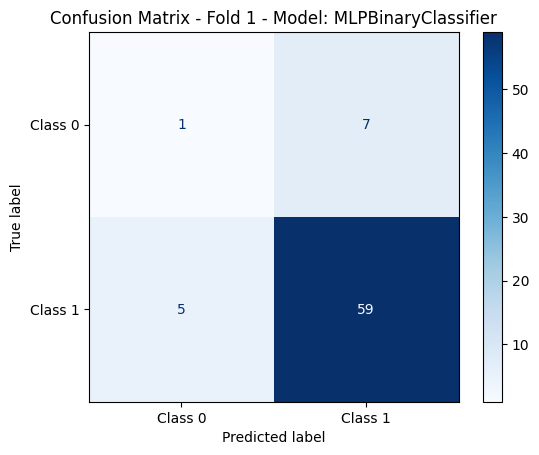


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Epoch [1/100], Train Loss: 1.0449, Val Loss: 1.3671, Train Acc: 0.8308, Val Acc: 0.8267
Epoch [2/100], Train Loss: 1.0641, Val Loss: 1.2146, Train Acc: 0.7669, Val Acc: 0.8267
Epoch [3/100], Train Loss: 1.0098, Val Loss: 1.1565, Train Acc: 0.8158, Val Acc: 0.8267
Epoch [4/100], Train Loss: 0.9137, Val Loss: 1.1303, Train Acc: 0.8421, Val Acc: 0.8133
Epoch [5/100], Train Loss: 0.9011, Val Loss: 1.1540, Train Acc: 0.8835, Val Acc: 0.8267
Epoch [6/100], Train Loss: 0.8068, Val Loss: 1.1149, Train Acc: 0.8459, Val Acc: 0.8533
Epoch [7/100], Train Loss: 0.7625, Val Loss: 1.1129, Train Acc: 0.8684, Val Acc: 0.8400
Epoch [8/100], Train Loss: 0.7572, Val Loss: 1.1309, Train Acc: 0.8722, Val Acc: 0.8933
Epoch [9/100], Train Loss: 0.7536, Val Loss: 1.1370, Train Acc: 0.8195, Val Acc: 0.8667
Epoch [10/100], Train Loss: 0.6791, Val Loss: 1.0909, Train Acc: 0.9286, Val Acc: 0.9067
Epoch [11/100], Train Loss: 0.5648, Val Loss

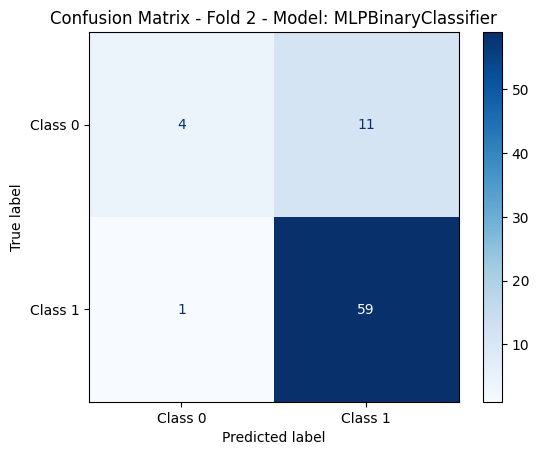


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Epoch [1/100], Train Loss: 1.1821, Val Loss: 0.9170, Train Acc: 0.6223, Val Acc: 0.8730
Epoch [2/100], Train Loss: 1.0402, Val Loss: 0.9242, Train Acc: 0.7878, Val Acc: 0.8571
Epoch [3/100], Train Loss: 0.9503, Val Loss: 0.9274, Train Acc: 0.8165, Val Acc: 0.8730
Epoch [4/100], Train Loss: 0.8990, Val Loss: 0.9471, Train Acc: 0.8381, Val Acc: 0.8730
Epoch [5/100], Train Loss: 0.9014, Val Loss: 0.9551, Train Acc: 0.8525, Val Acc: 0.8730
Epoch [6/100], Train Loss: 0.8126, Val Loss: 0.9364, Train Acc: 0.8561, Val Acc: 0.8730
Epoch [7/100], Train Loss: 0.7291, Val Loss: 0.9169, Train Acc: 0.8741, Val Acc: 0.8730
Epoch [8/100], Train Loss: 0.6595, Val Loss: 0.9751, Train Acc: 0.8993, Val Acc: 0.8730
Epoch [9/100], Train Loss: 0.5587, Val Loss: 1.0365, Train Acc: 0.9281, Val Acc: 0.8730
Epoch [10/100], Train Loss: 0.5471, Val Loss: 1.0551, Train Acc: 0.9353, Val Acc: 0.8730
Epoch [11/100], Train Loss: 0.5071, Val Loss

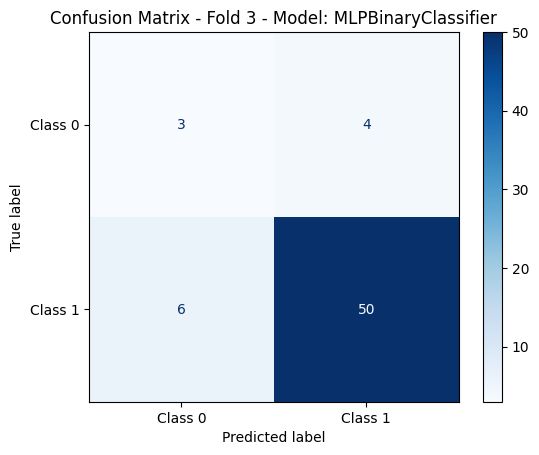


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Epoch [1/100], Train Loss: 1.1780, Val Loss: 0.9837, Train Acc: 0.5699, Val Acc: 0.8387
Epoch [2/100], Train Loss: 1.0874, Val Loss: 0.9732, Train Acc: 0.7240, Val Acc: 0.8387
Epoch [3/100], Train Loss: 0.9667, Val Loss: 0.9245, Train Acc: 0.8208, Val Acc: 0.8387
Epoch [4/100], Train Loss: 0.9749, Val Loss: 0.9561, Train Acc: 0.8065, Val Acc: 0.8387
Epoch [5/100], Train Loss: 0.9262, Val Loss: 0.9981, Train Acc: 0.7957, Val Acc: 0.8387
Epoch [6/100], Train Loss: 0.8978, Val Loss: 1.0289, Train Acc: 0.7885, Val Acc: 0.8387
Epoch [7/100], Train Loss: 0.8667, Val Loss: 1.0398, Train Acc: 0.8172, Val Acc: 0.8387
Epoch [8/100], Train Loss: 0.8190, Val Loss: 0.9556, Train Acc: 0.8136, Val Acc: 0.8387
Epoch [9/100], Train Loss: 0.8116, Val Loss: 0.9120, Train Acc: 0.7993, Val Acc: 0.8548
Epoch [10/100], Train Loss: 0.6677, Val Loss: 0.9214, Train Acc: 0.8136, Val Acc: 0.8548
Epoch [11/100], Train Loss: 0.6932, Val Loss

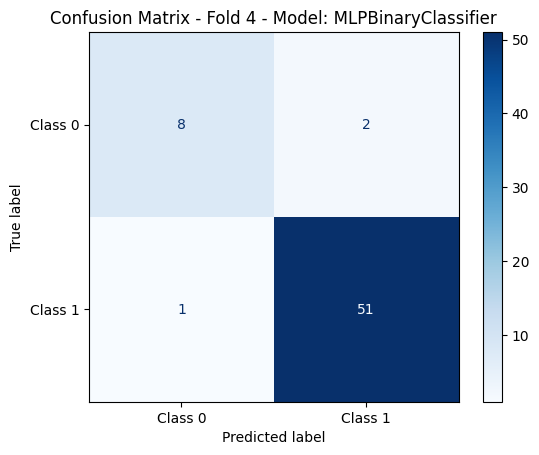


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Epoch [1/100], Train Loss: 1.1379, Val Loss: 0.7918, Train Acc: 0.7610, Val Acc: 0.8986
Epoch [2/100], Train Loss: 1.0838, Val Loss: 0.7490, Train Acc: 0.7868, Val Acc: 0.8841
Epoch [3/100], Train Loss: 1.0348, Val Loss: 0.7805, Train Acc: 0.7316, Val Acc: 0.8551
Epoch [4/100], Train Loss: 0.9458, Val Loss: 0.7352, Train Acc: 0.8051, Val Acc: 0.8986
Epoch [5/100], Train Loss: 0.8954, Val Loss: 0.7568, Train Acc: 0.8162, Val Acc: 0.8261
Epoch [6/100], Train Loss: 0.8755, Val Loss: 0.7576, Train Acc: 0.8603, Val Acc: 0.8696
Epoch [7/100], Train Loss: 0.8292, Val Loss: 0.9006, Train Acc: 0.8382, Val Acc: 0.7246
Epoch [8/100], Train Loss: 0.7279, Val Loss: 0.8048, Train Acc: 0.8603, Val Acc: 0.8551
Epoch [9/100], Train Loss: 0.6524, Val Loss: 0.8957, Train Acc: 0.8640, Val Acc: 0.7971
Epoch [10/100], Train Loss: 0.7589, Val Loss: 0.8953, Train Acc: 0.8860, Val Acc: 0.7971
Epoch [11/100], Train Loss: 0.6601, Val Loss

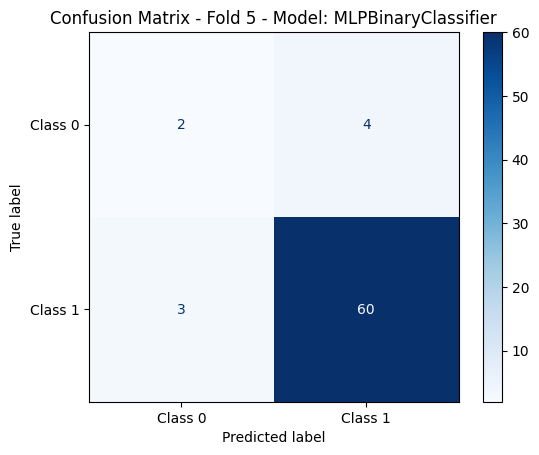


Model: MLPBinaryClassifier - Average Validation Accuracy: 0.8730
Average Precision: 0.9125
Average Recall: 0.9462
Average F1 Score: 0.9282
Average AUC-ROC: 0.7599

=== Benchmarking Model: ResidualMLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 1.0105, Val Loss: 1.2362, Train Acc: 0.7435, Val Acc: 0.7917
Epoch [2/100], Train Loss: 0.7209, Val Loss: 1.2528, Train Acc: 0.8476, Val Acc: 0.7083
Epoch [3/100], Train Loss: 0.5805, Val Loss: 1.5082, Train Acc: 0.8662, Val Acc: 0.8194
Epoch [4/100], Train Loss: 0.5663, Val Loss: 1.5149, Train Acc: 0.8959, Val Acc: 0.5833
Epoch [5/100], Train Loss: 0.4832, Val Loss: 1.5483, Train Acc: 0.8959, Val Acc: 0.7361
Epoch [6/100], Train Loss: 0.2991, Val Loss: 2.2086, Train Acc: 0.9331, Val Acc: 0.8472
Epoch [7/100], Train Loss: 0.3387, Val Loss: 2.2625, Train Acc: 0.9331, Val Acc: 0.8472
Epoch [8/100], Train Loss: 0.3388, Val Loss: 2.5228, Train Acc: 0.9219, Val Acc: 0.8472

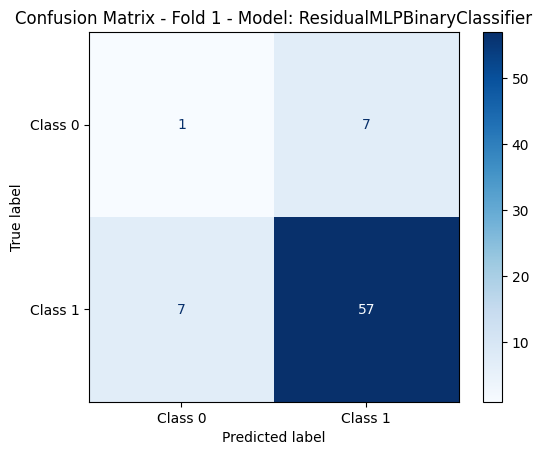


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Epoch [1/100], Train Loss: 1.5997, Val Loss: 1.1923, Train Acc: 0.5376, Val Acc: 0.8267
Epoch [2/100], Train Loss: 0.9393, Val Loss: 1.1519, Train Acc: 0.8045, Val Acc: 0.8267
Epoch [3/100], Train Loss: 0.8678, Val Loss: 1.1896, Train Acc: 0.8910, Val Acc: 0.8133
Epoch [4/100], Train Loss: 0.8654, Val Loss: 1.5686, Train Acc: 0.7256, Val Acc: 0.8400
Epoch [5/100], Train Loss: 0.6508, Val Loss: 1.2658, Train Acc: 0.8985, Val Acc: 0.8667
Epoch [6/100], Train Loss: 0.6176, Val Loss: 1.5962, Train Acc: 0.8609, Val Acc: 0.8933
Epoch [7/100], Train Loss: 0.4503, Val Loss: 2.1150, Train Acc: 0.9135, Val Acc: 0.8933
Epoch [8/100], Train Loss: 0.4042, Val Loss: 1.8839, Train Acc: 0.9173, Val Acc: 0.8533
Epoch [9/100], Train Loss: 0.2844, Val Loss: 2.0380, Train Acc: 0.9549, Val Acc: 0.9067
Epoch [10/100], Train Loss: 0.2522, Val Loss: 2.8616, Train Acc: 0.9323, Val Acc: 0.8400
Epoch [11/100], Train Loss: 0.3771, Val Loss

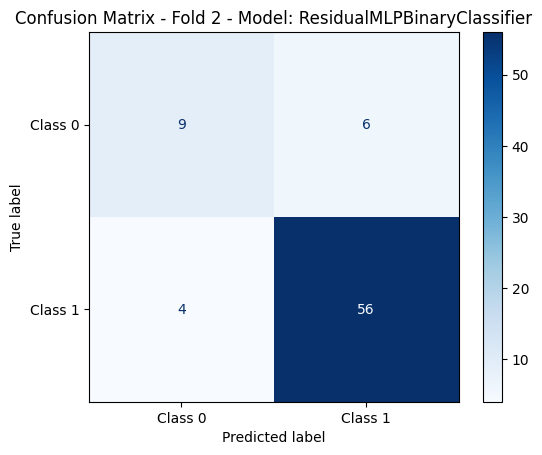


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Epoch [1/100], Train Loss: 1.1336, Val Loss: 1.0446, Train Acc: 0.6942, Val Acc: 0.8571
Epoch [2/100], Train Loss: 0.8366, Val Loss: 1.1712, Train Acc: 0.7950, Val Acc: 0.8730
Epoch [3/100], Train Loss: 0.7382, Val Loss: 1.5003, Train Acc: 0.8345, Val Acc: 0.8730
Epoch [4/100], Train Loss: 0.7752, Val Loss: 1.2426, Train Acc: 0.8345, Val Acc: 0.7937
Epoch [5/100], Train Loss: 0.5913, Val Loss: 1.3726, Train Acc: 0.8777, Val Acc: 0.8254
Epoch [6/100], Train Loss: 0.3876, Val Loss: 1.9325, Train Acc: 0.9353, Val Acc: 0.8730
Epoch [7/100], Train Loss: 0.4891, Val Loss: 2.1202, Train Acc: 0.8921, Val Acc: 0.8730
Epoch [8/100], Train Loss: 0.4329, Val Loss: 1.7303, Train Acc: 0.9065, Val Acc: 0.8571
Epoch [9/100], Train Loss: 0.3170, Val Loss: 1.7540, Train Acc: 0.9496, Val Acc: 0.8571
Epoch [10/100], Train Loss: 0.2755, Val Loss: 2.1640, Train Acc: 0.9532, Val Acc: 0.8571
Epoch [11/100], Train Loss: 0.2741, Val Loss

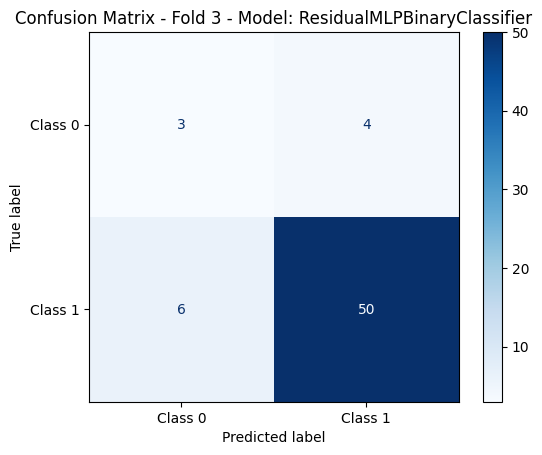


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Epoch [1/100], Train Loss: 1.0540, Val Loss: 0.8687, Train Acc: 0.7455, Val Acc: 0.8387
Epoch [2/100], Train Loss: 1.0619, Val Loss: 0.7206, Train Acc: 0.7419, Val Acc: 0.8226
Epoch [3/100], Train Loss: 0.9084, Val Loss: 0.9019, Train Acc: 0.7921, Val Acc: 0.4839
Epoch [4/100], Train Loss: 0.9490, Val Loss: 0.6826, Train Acc: 0.7455, Val Acc: 0.9194
Epoch [5/100], Train Loss: 0.7662, Val Loss: 0.7619, Train Acc: 0.8208, Val Acc: 0.9194
Epoch [6/100], Train Loss: 0.6246, Val Loss: 0.6077, Train Acc: 0.8638, Val Acc: 0.9032
Epoch [7/100], Train Loss: 0.5341, Val Loss: 0.7217, Train Acc: 0.8817, Val Acc: 0.7581
Epoch [8/100], Train Loss: 0.6509, Val Loss: 0.6872, Train Acc: 0.7670, Val Acc: 0.9516
Epoch [9/100], Train Loss: 0.5128, Val Loss: 0.8576, Train Acc: 0.8208, Val Acc: 0.9677
Epoch [10/100], Train Loss: 0.2851, Val Loss: 1.0316, Train Acc: 0.9355, Val Acc: 0.9677
Epoch [11/100], Train Loss: 0.2829, Val Loss

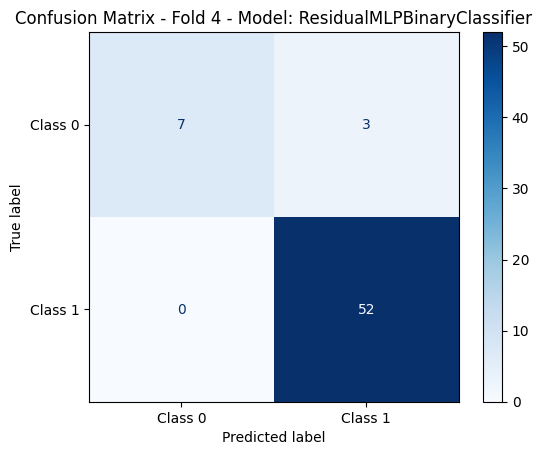


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Epoch [1/100], Train Loss: 1.4511, Val Loss: 0.7812, Train Acc: 0.6838, Val Acc: 0.8696
Epoch [2/100], Train Loss: 1.0480, Val Loss: 0.8321, Train Acc: 0.6912, Val Acc: 0.7391
Epoch [3/100], Train Loss: 0.9061, Val Loss: 0.6916, Train Acc: 0.7500, Val Acc: 0.8986
Epoch [4/100], Train Loss: 0.8223, Val Loss: 0.7971, Train Acc: 0.7610, Val Acc: 0.9275
Epoch [5/100], Train Loss: 0.6999, Val Loss: 0.8114, Train Acc: 0.8640, Val Acc: 0.7971
Epoch [6/100], Train Loss: 0.5326, Val Loss: 0.9089, Train Acc: 0.9007, Val Acc: 0.8696
Epoch [7/100], Train Loss: 0.4691, Val Loss: 1.0443, Train Acc: 0.9007, Val Acc: 0.8261
Epoch [8/100], Train Loss: 0.4252, Val Loss: 1.1185, Train Acc: 0.9154, Val Acc: 0.8406
Epoch [9/100], Train Loss: 0.3747, Val Loss: 1.1761, Train Acc: 0.9412, Val Acc: 0.8406
Epoch [10/100], Train Loss: 0.1867, Val Loss: 1.4713, Train Acc: 0.9596, Val Acc: 0.8841
Epoch [11/100], Train Loss: 0.1811, Val Loss

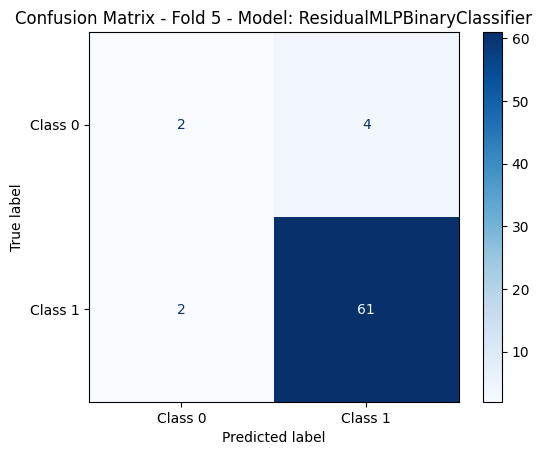


Model: ResidualMLPBinaryClassifier - Average Validation Accuracy: 0.8756
Average Precision: 0.9207
Average Recall: 0.9370
Average F1 Score: 0.9286
Average AUC-ROC: 0.7560

=== Benchmarking Model: EnhancedCNNMLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 1.0902, Val Loss: 1.0634, Train Acc: 0.6171, Val Acc: 0.8889
Epoch [2/100], Train Loss: 0.8068, Val Loss: 1.0875, Train Acc: 0.7844, Val Acc: 0.1111
Epoch [3/100], Train Loss: 0.7087, Val Loss: 1.2080, Train Acc: 0.8141, Val Acc: 0.1111
Epoch [4/100], Train Loss: 0.6830, Val Loss: 1.1877, Train Acc: 0.8476, Val Acc: 0.1111
Epoch [5/100], Train Loss: 0.5754, Val Loss: 1.0737, Train Acc: 0.8401, Val Acc: 0.4583
Epoch [6/100], Train Loss: 0.5632, Val Loss: 1.2072, Train Acc: 0.8587, Val Acc: 0.2222
Epoch [7/100], Train Loss: 0.4825, Val Loss: 1.0846, Train Acc: 0.8922, Val Acc: 0.4722
Epoch [8/100], Train Loss: 0.5106, Val Loss: 1.0506, Train Acc: 0.8996, Val 

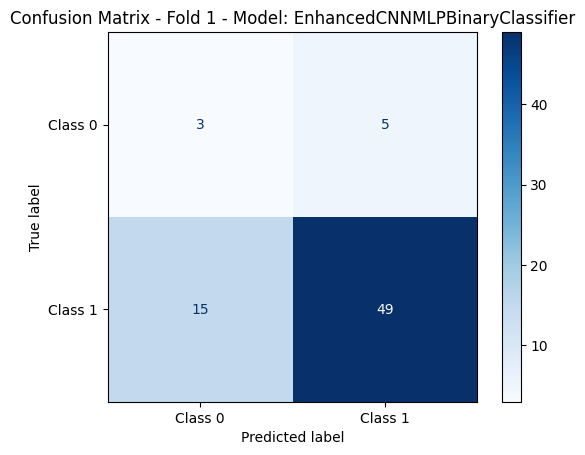


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Epoch [1/100], Train Loss: 1.0771, Val Loss: 1.5743, Train Acc: 0.6617, Val Acc: 0.8000
Epoch [2/100], Train Loss: 0.8558, Val Loss: 1.6840, Train Acc: 0.7744, Val Acc: 0.8000
Epoch [3/100], Train Loss: 0.7940, Val Loss: 1.2612, Train Acc: 0.7744, Val Acc: 0.2400
Epoch [4/100], Train Loss: 0.7027, Val Loss: 1.3109, Train Acc: 0.7782, Val Acc: 0.2000
Epoch [5/100], Train Loss: 0.6225, Val Loss: 1.2780, Train Acc: 0.8308, Val Acc: 0.2533
Epoch [6/100], Train Loss: 0.5587, Val Loss: 1.2612, Train Acc: 0.8534, Val Acc: 0.3200
Epoch [7/100], Train Loss: 0.4907, Val Loss: 1.2825, Train Acc: 0.8684, Val Acc: 0.3200
Epoch [8/100], Train Loss: 0.5025, Val Loss: 1.3064, Train Acc: 0.8609, Val Acc: 0.3600
Epoch [9/100], Train Loss: 0.4266, Val Loss: 1.5338, Train Acc: 0.8985, Val Acc: 0.2133
Epoch [10/100], Train Loss: 0.4009, Val Loss: 1.5811, Train Acc: 0.9248, Val Acc: 0.3067
Epoch [11/100], Train Loss: 0.3582, Val Loss

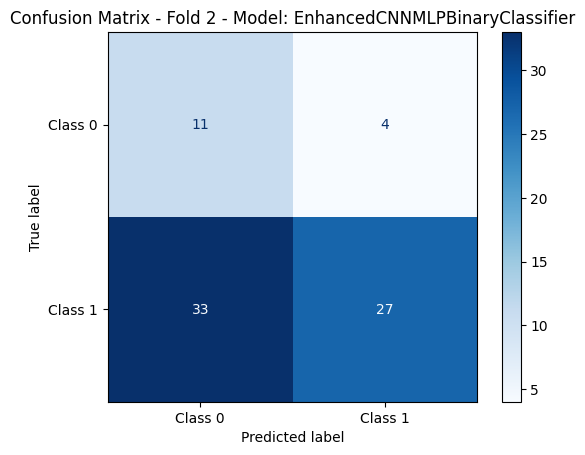


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Epoch [1/100], Train Loss: 1.1101, Val Loss: 1.0595, Train Acc: 0.7410, Val Acc: 0.8889
Epoch [2/100], Train Loss: 0.8562, Val Loss: 1.0509, Train Acc: 0.7914, Val Acc: 0.8889
Epoch [3/100], Train Loss: 0.7728, Val Loss: 1.0107, Train Acc: 0.8237, Val Acc: 0.8413
Epoch [4/100], Train Loss: 0.7112, Val Loss: 1.1145, Train Acc: 0.8129, Val Acc: 0.1587
Epoch [5/100], Train Loss: 0.6490, Val Loss: 1.1589, Train Acc: 0.8165, Val Acc: 0.1587
Epoch [6/100], Train Loss: 0.5867, Val Loss: 1.2898, Train Acc: 0.8417, Val Acc: 0.1429
Epoch [7/100], Train Loss: 0.4922, Val Loss: 1.4435, Train Acc: 0.8849, Val Acc: 0.1270
Epoch [8/100], Train Loss: 0.4930, Val Loss: 1.1768, Train Acc: 0.8813, Val Acc: 0.3651
Epoch [9/100], Train Loss: 0.4452, Val Loss: 1.0554, Train Acc: 0.9101, Val Acc: 0.5079
Epoch [10/100], Train Loss: 0.3946, Val Loss: 1.3161, Train Acc: 0.9137, Val Acc: 0.3810
Epoch [11/100], Train Loss: 0.4053, Val Loss

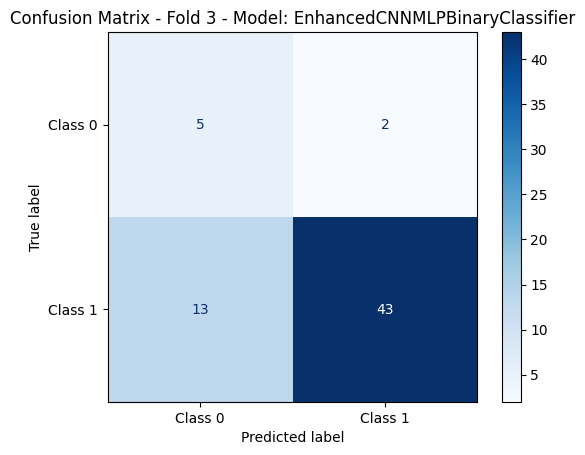


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Epoch [1/100], Train Loss: 1.1659, Val Loss: 1.2456, Train Acc: 0.5520, Val Acc: 0.1613
Epoch [2/100], Train Loss: 0.9430, Val Loss: 1.2062, Train Acc: 0.6846, Val Acc: 0.1613
Epoch [3/100], Train Loss: 0.8479, Val Loss: 1.2404, Train Acc: 0.7491, Val Acc: 0.1613
Epoch [4/100], Train Loss: 0.7950, Val Loss: 1.2911, Train Acc: 0.7491, Val Acc: 0.1613
Epoch [5/100], Train Loss: 0.7195, Val Loss: 1.3932, Train Acc: 0.7957, Val Acc: 0.1613
Epoch [6/100], Train Loss: 0.6072, Val Loss: 1.3348, Train Acc: 0.8136, Val Acc: 0.2258
Epoch [7/100], Train Loss: 0.5981, Val Loss: 1.5148, Train Acc: 0.8280, Val Acc: 0.2258
Epoch [8/100], Train Loss: 0.5752, Val Loss: 1.1501, Train Acc: 0.8495, Val Acc: 0.3871
Epoch [9/100], Train Loss: 0.4582, Val Loss: 1.0465, Train Acc: 0.8674, Val Acc: 0.5161
Epoch [10/100], Train Loss: 0.4423, Val Loss: 1.1208, Train Acc: 0.8961, Val Acc: 0.4839
Epoch [11/100], Train Loss: 0.3851, Val Loss

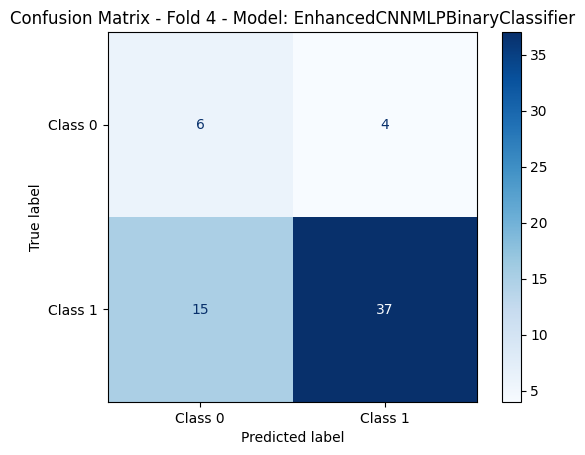


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Epoch [1/100], Train Loss: 1.1021, Val Loss: 0.9531, Train Acc: 0.6434, Val Acc: 0.9130
Epoch [2/100], Train Loss: 0.8795, Val Loss: 1.0035, Train Acc: 0.7279, Val Acc: 0.0870
Epoch [3/100], Train Loss: 0.8866, Val Loss: 1.1339, Train Acc: 0.7794, Val Acc: 0.0870
Epoch [4/100], Train Loss: 0.7422, Val Loss: 1.0782, Train Acc: 0.8015, Val Acc: 0.2754
Epoch [5/100], Train Loss: 0.6302, Val Loss: 1.0074, Train Acc: 0.8419, Val Acc: 0.3623
Epoch [6/100], Train Loss: 0.5674, Val Loss: 0.9937, Train Acc: 0.8272, Val Acc: 0.4928
Epoch [7/100], Train Loss: 0.5809, Val Loss: 0.8171, Train Acc: 0.8787, Val Acc: 0.7101
Epoch [8/100], Train Loss: 0.4774, Val Loss: 0.9004, Train Acc: 0.8860, Val Acc: 0.5362
Epoch [9/100], Train Loss: 0.4758, Val Loss: 0.8366, Train Acc: 0.8934, Val Acc: 0.7536
Epoch [10/100], Train Loss: 0.4230, Val Loss: 0.7658, Train Acc: 0.8971, Val Acc: 0.7971
Epoch [11/100], Train Loss: 0.3928, Val Loss

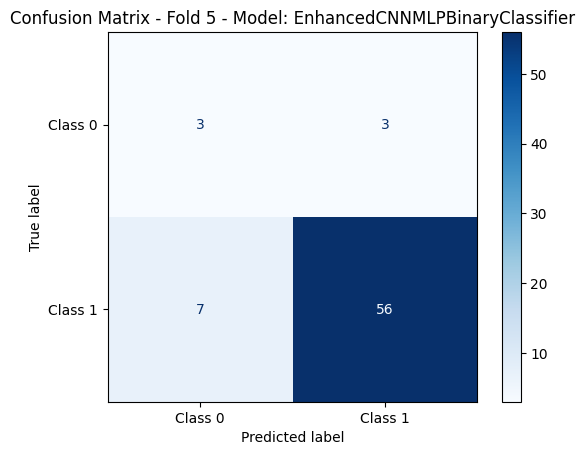


Model: EnhancedCNNMLPBinaryClassifier - Average Validation Accuracy: 0.7079
Average Precision: 0.9171
Average Recall: 0.7168
Average F1 Score: 0.7978
Average AUC-ROC: 0.7401

=== Benchmark Results ===

Model: MLPBinaryClassifier
Avg Validation Accuracy: 0.8730
Avg Precision: 0.9125
Avg Recall: 0.9462
Avg F1 Score: 0.9282
Avg AUC-ROC: 0.7599


Model: ResidualMLPBinaryClassifier
Avg Validation Accuracy: 0.8756
Avg Precision: 0.9207
Avg Recall: 0.9370
Avg F1 Score: 0.9286
Avg AUC-ROC: 0.7560


Model: EnhancedCNNMLPBinaryClassifier
Avg Validation Accuracy: 0.7079
Avg Precision: 0.9171
Avg Recall: 0.7168
Avg F1 Score: 0.7978
Avg AUC-ROC: 0.7401




In [25]:
# Import necessary libraries and your custom model classes
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from torch import nn

# Assume `dataset` is your Dataset object and `df_iso` is your DataFrame with class labels.

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of model classes to benchmark
model_classes = [
    #EnhancedCNNMLPBinaryClassifier,
    MLPBinaryClassifier,
    ResidualMLPBinaryClassifier,
    EnhancedCNNMLPBinaryClassifier

]

# Run the benchmark on all models
results = benchmark_models(
    dataset=dataset,
    df=df_iso,
    device=device,
    model_classes=model_classes,
    num_epochs=100,               # Use a lower number of epochs to start, increase if needed
    batch_size=16,
    learning_rate=0.001,
    hidden_dim=64,               # For transformer or other models needing hidden dimension
    pos_weight=1,
    neg_weight=6,
    k_folds=5,
    augment_minority_class=True, # If your dataset is imbalanced
    weight_decay=0.001,
    patience=10
)

# Displaying benchmark results
print("\n=== Benchmark Results ===\n")
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\n" + "="*30 + "\n")


Testing on Bintu Model

In [38]:
import h5py
import torch

# Load the HDF5 file
with h5py.File(data, "r") as h5_file:
    # Get the list of protein IDs (keys)
    protein_ids = list(h5_file.keys())

    # Loop through the first 5 proteins and print their embeddings
    for i, protein_id in enumerate(protein_ids[:5]):
        embedding = h5_file[protein_id][()]  # Load the numpy array for each protein
        embedding_tensor = torch.tensor(embedding)  # Convert to a PyTorch tensor
        print(f"Protein ID: {protein_id}")
        print("Embedding:", embedding_tensor.shape)
        print()  # Print a new line for readability


Protein ID: AEBP2-2
Embedding: torch.Size([1024])

Protein ID: AEBP2-3
Embedding: torch.Size([1024])

Protein ID: ARNT2-1
Embedding: torch.Size([1024])

Protein ID: ARNT2-2
Embedding: torch.Size([1024])

Protein ID: ARNT2-3
Embedding: torch.Size([1024])

